## Loading necessary Libraries

In [1]:
import kagglehub
import numpy as np
import os
dataset_path = kagglehub.dataset_download("jessicali9530/stl10")
print(dataset_path)

/root/.cache/kagglehub/datasets/jessicali9530/stl10/versions/3


## Files in Directory

In [2]:
import os

dataset_path = "/root/.cache/kagglehub/datasets/jessicali9530/stl10/versions/3"

print("Files in Dataset Directory:", os.listdir(dataset_path))


Files in Dataset Directory: ['test_images', 'unlabeled_images', 'train_images']


In [3]:
import os
import tensorflow as tf
dataset_path = "/root/.cache/kagglehub/datasets/jessicali9530/stl10/versions/3"
train_images_path = os.path.join(dataset_path, "train_images")
test_images_path = os.path.join(dataset_path, "test_images")

print("Train Images Path:", train_images_path)
print("Test Images Path:", test_images_path)


Train Images Path: /root/.cache/kagglehub/datasets/jessicali9530/stl10/versions/3/train_images
Test Images Path: /root/.cache/kagglehub/datasets/jessicali9530/stl10/versions/3/test_images


## Loading the dataset

In [4]:
dataset_path = "/root/.cache/kagglehub/datasets/jessicali9530/stl10/versions/3"
train_images_path = os.path.join(dataset_path, "train_images")

IMG_SIZE = (96, 96)
BATCH_SIZE = 64

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_images_path,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode=None
)

Found 5000 files.


## Preprocessing and Encoder and Decoder

In [5]:
def preprocess(image):
    return tf.cast(image, tf.float32) / 255.0

train_dataset = train_dataset.map(lambda x: preprocess(x))
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)


def build_encoder():
    inputs = layers.Input(shape=(96, 96, 3))
    x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(inputs)
    x = layers.MaxPooling2D((2, 2), padding="same")(x)
    x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(x)
    x = layers.MaxPooling2D((2, 2), padding="same")(x)
    x = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(x)
    x = layers.MaxPooling2D((2, 2), padding="same")(x)
    encoded = layers.GlobalAveragePooling2D()(x)
    return models.Model(inputs, encoded, name="Encoder")


def build_decoder():
    inputs = layers.Input(shape=(128,))
    x = layers.Dense(12 * 12 * 128, activation="relu")(inputs)
    x = layers.Reshape((12, 12, 128))(x)
    x = layers.Conv2DTranspose(128, (3, 3), activation="relu", padding="same")(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2DTranspose(64, (3, 3), activation="relu", padding="same")(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2DTranspose(32, (3, 3), activation="relu", padding="same")(x)
    x = layers.UpSampling2D((2, 2))(x)
    decoded = layers.Conv2DTranspose(3, (3, 3), activation="sigmoid", padding="same")(x)
    return models.Model(inputs, decoded, name="Decoder")


## Building Model

In [6]:
from tensorflow.keras  import layers
from tensorflow.keras import models


encoder = build_encoder()
decoder = build_decoder()

inputs = layers.Input(shape=(96, 96, 3))
encoded_output = encoder(inputs)
decoded_output = decoder(encoded_output)

autoencoder = models.Model(inputs, decoded_output, name="Autoencoder")
autoencoder.compile(optimizer="adam", loss="mse")


print(autoencoder.summary())
train_dataset = train_dataset.map(lambda x: (x, x))


Model: "Autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Encoder (Functional)                 │ (None, 128)                 │          93,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Decoder (Functional)                 │ (None, 96, 96, 3)           │       2,618,435 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,711,683 (10.34 MB)

 Trainable params: 2,711,683 (10.34 MB)

 Non-trainable params: 0 (0.00 B)

None


## Fitting the model

In [7]:
EPOCHS = 20
history = autoencoder.fit(train_dataset, epochs=EPOCHS)

Epoch 1/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 18s 128ms/step - loss: 0.0678
Epoch 2/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0516
Epoch 3/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0429
Epoch 4/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0394
Epoch 5/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 0.0380
Epoch 6/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0375
Epoch 7/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 0.0366
Epoch 8/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - loss: 0.0351
Epoch 9/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 0.0343
Epoch 10/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - loss: 0.0337
Epoch 11/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 0.0333
Epoch 12/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0329
Epoch 13/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 0.0331
Epoch 14/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 0.0321
Epoch 15/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0320
Ep

## Visualization

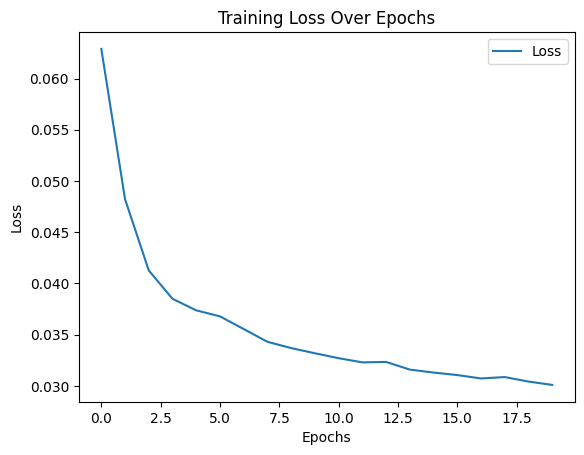

In [8]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.legend()
plt.show()
